In [296]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [297]:
thetadata_start = '2021-01-01'

In [298]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
key = 11
with open(f'../input/profitable_weights_{key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../input/profitable_trades_{key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
# AMZN20220329LONG
# ttrades__ = ttrades__[ttrades__.index != 5]
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,25,502,506,249.189127,225.660004,-588.228092,-0.094423,2024-01-03,2024-01-09,6,BA
1,71,502,533,184.864771,183.419998,-102.578887,-0.007815,2024-01-03,2024-02-16,44,AAPL
2,129,502,585,136.184992,145.509995,1202.925357,0.068473,2024-01-03,2024-05-02,120,AMD
3,48,502,637,346.187441,475.000000,6183.002831,0.372089,2024-01-03,2024-07-18,197,META
4,17,502,752,653.489257,923.650024,4592.733045,0.413413,2024-01-03,2024-12-31,363,COST
5,14,502,752,468.955627,901.799988,6059.821046,0.922996,2024-01-03,2024-12-31,363,NFLX
6,642,509,752,54.811169,138.029999,53426.488764,1.518282,2024-01-12,2024-12-31,354,NVDA
7,23,521,643,157.549500,180.389999,525.331486,0.144973,2024-01-31,2024-07-26,177,AMZN
8,96,529,530,97.259218,94.849998,-231.285090,-0.024771,2024-02-12,2024-02-13,1,SBUX
9,119,588,617,156.867127,156.990005,14.622499,0.000783,2024-05-07,2024-06-18,42,AMD


In [299]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)


max_cash = {}
cash = 20_000
for s, w in weights.items():
    if w * cash > 200:
        max_cash[s] = 2
    elif w * cash > 100:
        max_cash[s] = 1
    else:
        max_cash[s] = 0.5
max_cash
pd.Series(weights).sort_values(ascending=False), max_cash

(NVDA    0.252721
 TSLA    0.131504
 AMD     0.126411
 META    0.121701
 AAPL    0.094712
 COST    0.082623
 SBUX    0.067407
 NFLX    0.049660
 BA      0.046367
 AMZN    0.026893
 dtype: float64,
 {'NVDA': 2,
  'TSLA': 2,
  'AMD': 2,
  'META': 2,
  'AAPL': 2,
  'NFLX': 2,
  'COST': 2,
  'SBUX': 2,
  'BA': 2,
  'AMZN': 2})

In [300]:

# from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
# from pandas.tseries.offsets import BDay

# rm = RiskManager(None, None, 1000000)
# rm.OrderPicker.liquidity_threshold = 2
# rm.OrderPicker.lookback = 10
# rm.OrderPicker.data_availability_threshold = 0.15
# date, tick = '2023-07-05', 'AVGO'
# date, tick = '2024-08-13', 'TSM'
# start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
# right = 'C'
# order_settings = {'type': 'spread',
#  'specifics': [{'direction': 'long',
#    'rel_strike': .50,
#    'dte': 210,
#    'moneyness_width': 0.5},
#   #  {'direction': 'short',
#   # 'rel_strike': .60,
#   # 'dte': 270,
#   # 'moneyness_width': 0.35}
# ],
#  'name': 'vertical_spread'}



# order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
# order

In [301]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo

pd.options.display.max_rows = 15
pd.options.display.max_columns = 15

evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)
evb_backtest.portfolio.initial_capital
w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .850,
   'dte': 365,
   'moneyness_width': 0.35},
   {'direction': 'short',
  'rel_strike': .60,
  'dte': 365,
  'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = max_cash
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.executor.commission_rate
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.roll_map = 30
evb_backtest.portfolio.allocated_cash_map
evb_backtest.portfolio.max_contract_price
evb_backtest.portfolio.roll_map
evb_backtest.portfolio.allocated_cash_map
evb_backtest.portfolio.max_contract_price
evb_backtest.portfolio.dte_reduction_factor = 60

for key  in max_cash:
    if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
        print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])



signals = evb_backtest.bars.signal_df
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

20.0

## Problems:

- Current Problem: SELL Signal and Buy Signal are put right next to each other in the queue. Whereas, it is meant to be Sell Signal -> Order Event -> Fill Event -> Buy Signal -> Order Event -> Fill Event

Solution:
- Use a tuple of action ```python['CLOSE', 'OPEN']```
- Put first action into queue and return ffunctionality to backtester. Backtester then handles all corresponding sequence.
- Do the same for action two.

In [302]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

Processing event: MARKET
Processing event: SIGNAL
Buy Details
Position: {'long': ['BA20250117C360'], 'short': ['BA20250117C390'], 'trade_id': '&L:BA20250117C360&S:BA20250117C390', 'close': 1.8149999999999995}, Date: 2024-01-03, Signal: SignalEvent type:LONG, symbol=BA, date:2024-01-03 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:BA20240103LONG
Max Contract Price: 2, Cash at Hand: 7.094147050141492
Cash at Hand 7.094147050141492 Close 1.8149999999999995
Processing event: SIGNAL
Buy Details
Position: {'long': ['AAPL20250117C220'], 'short': ['AAPL20241220C225'], 'trade_id': '&L:AAPL20250117C220&S:AAPL20241220C225', 'close': 2.0}, Date: 2024-01-03, Signal: SignalEvent type:LONG, symbol=AAPL, date:2024-01-03 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:AAPL20240103LONG
Max Contract Price: 2, Cash at Hand: 14.490955649250246
Cash at Hand 14.490955649250246 Close 2.0
Processing event: SIGNAL
Buy Details
Position: {'long': ['AMD20250117C185'], 'short':

In [312]:
pd.set_option('display.max_rows', 100)
transactions=evb_backtest.portfolio.transactions
transactions[transactions.symbol=='COST']

,signal_id,datetime,symbol,direction,cash_before,cash_after
4,COST20240103LONG,2024-01-03,COST,BUY,1404.596446,138.558297
30,COST20240103LONG,2024-12-18,COST,SELL,138.558297,18854.336565
31,COST20240103LONG,2024-12-18,COST,BUY,18854.336565,1879.024363
38,COST20240103LONG,2024-12-31,COST,SELL,1879.024363,22316.212878


In [304]:
from EventDriven.execution import exec_cache
idx = 10
buys = [x  for x in exec_cache['fill'].values() if x.direction == 'BUY']
buy1 = buys[idx]
print("Buy")
print(buy1.datetime,buy1.fill_cost/buy1.quantity, buy1.market_value)

sells = [x  for x in exec_cache['fill'].values() if x.direction == 'SELL']
sell1 = sells[idx]
print("Sell")
print(sell1.datetime,sell1.fill_cost/sell1.quantity, sell1.market_value, len(exec_cache['fill']))


Buy
2022-02-01 00:00:00 2.0717056101140923 32.93928976182548
Sell
2022-03-14 00:00:00 0.6495823607022932 3.9754941642137593 180


In [305]:
tsla_buys = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'BUY']
tsla_sells = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'SELL']
tsla_buys, tsla_sells

([<EventDriven.event.FillEvent at 0x141c02350>,
  <EventDriven.event.FillEvent at 0x148d367d0>])

In [306]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50
trades = evb_backtest.portfolio._trades.copy()#
len(trades)
# len(trades['SignalID'].unique())
trades[['Positions','Ticker','PnL', 'ReturnPct', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'Quantity', 'SignalID', 'Duration']]
trades[['SignalID', 'Ticker', 'ReturnPct', 'Positions', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue']]

,SignalID,Ticker,ReturnPct,Positions,EntryTime,ExitTime,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue
0,BA20240103LONG,BA,-0.422776,&L:BA20250117C360&S:BA20250117C390,2024-01-03,2024-01-09,186.266585,107.517558,554.899754,326.452673
1,AAPL20240103LONG,AAPL,-0.300997,&L:AAPL20250117C220&S:AAPL20241220C225,2024-01-03,2024-02-16,213.051326,148.923607,1270.507957,901.341643
2,AMD20240103LONG,AMD,0.024272,&L:AMD20250117C185&S:AMD20250117C195,2024-01-03,2024-05-02,201.187726,206.070856,1798.989534,1866.337701
3,META20240103LONG,META,0.663816,&L:META20250117C420&S:META20250117C425,2024-01-03,2024-07-18,190.238664,316.522126,1700.447972,2860.399133
4,COST20240103LONG,COST,13.782950,&L:COST20250117C780&S:COST20250117C785,2024-01-03,2024-12-18,33.316793,492.520481,1216.638148,18765.178267
5,NFLX20240103LONG,NFLX,6.334328,&L:NFLX20250117C560&S:NFLX20250117C570,2024-01-03,2024-12-19,132.511259,971.881050,656.056297,4865.905250
6,NVDA20240112LONG,NVDA,1.020260,&L:NVDA20250117C595&S:NVDA20250117C600,2024-01-12,2024-12-20,212.847385,430.007043,3807.852939,7763.526772
7,AMZN20240131LONG,AMZN,0.422045,&L:AMZN20250117C170&S:AMZN20250117C175,2024-01-31,2024-07-26,207.206546,294.657081,205.906546,295.957081
8,SBUX20240212LONG,SBUX,-0.244675,&L:SBUX20250117C115&S:SBUX20250117C130,2024-02-12,2024-02-13,210.156583,158.736522,835.426331,640.146089
9,AMD20240507LONG,AMD,-0.104703,&L:AMD20250620C160&S:AMD20250620C165,2024-05-07,2024-06-18,200.694228,179.681018,1794.548050,1628.829158


In [307]:
reasons = {
    x['reason']:0 for x in evb_backtest.portfolio.unprocessed_signals
}

for v in (evb_backtest.portfolio.unprocessed_signals):
    reasons[v['reason']] += 1
    print(v) 
reasons

{}

<Axes: xlabel='datetime'>

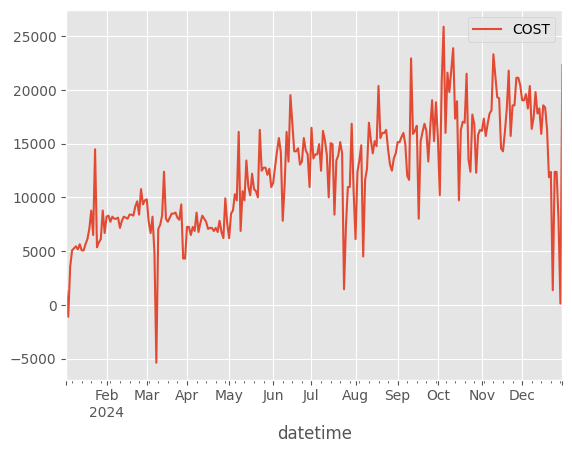

In [308]:
evb_backtest.portfolio._equity.plot(y = 'COST')

In [313]:
evb_backtest.portfolio.plot_portfolio()

In [310]:
evb_backtest.portfolio.aggregate()

Start                                                    2024-01-03 00:00:00
End                                                      2024-12-31 00:00:00
Duration                                                   363 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                     50840.2
Equity Peak [$]                                                 52522.932306
Return [%]                                                        159.873249
Buy & Hold Return [%]                                              54.777909
CAGR [%]                                                          161.244264
Volatility Ann. [%]                                               191.602377
Sharpe Ratio                                                        1.385737
Sortino Ratio                                                       2.245488
Skew                                                                1.627856

In [311]:
#&L:COST20230120C680&S:COST20230120C700
# 9	2022-01-11	COST	BUY	989.300187	165.485214
# 12	2022-01-21	COST	SELL	165.485214	33.494091
# &L:AAPL20230120C240&S:AAPL20230120C260	2022-01-04	2022-01-19
price_data = evb_backtest.portfolio.options_data['COST20230120C680'] - evb_backtest.portfolio.options_data['COST20230120C700']
price_data.plot(y = 'Midpoint')
price_data[(price_data.index >= '2022-01-04') & (price_data.index <= '2022-01-25')]
# price_data[price_data.index.isin(['2022-01-04', '2022-01-21'])]

KeyError: 'COST20230120C680'

In [156]:
price_data

,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2022-01-04,2.85,2.10,3.55,3.25,-100,50,1.75,39,4.95,3.350,3.042473
2022-01-05,4.10,3.80,5.10,4.75,-27,-41,3.50,61,5.35,4.425,6.236236
2022-01-06,4.41,4.14,4.41,4.19,-6,17,3.30,1,3.35,3.325,3.304925
2022-01-07,1.24,1.62,2.92,2.80,-7,55,2.40,4,2.90,2.650,2.180994
2022-01-10,1.99,2.46,2.36,1.98,-116,-33,1.85,0,2.15,2.000,2.047370
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.00,0.00,0.00,0.00,0,0,0.00,0,0.00,0.000,0.000000
2022-12-27,-0.01,-0.01,-0.01,-0.01,-10,0,0.00,3,0.03,0.015,0.030000
2022-12-28,0.00,0.00,0.00,0.00,0,0,0.00,-4,0.00,0.000,0.000000


In [152]:
(1.235/1.950)-1

-0.3666666666666666

In [63]:

pd.set_option('display.max_rows', 10000)
evb_backtest.portfolio.get_all_positions()

long                short  \
datetime   symbol                                             
2022-01-04 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-05 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-06 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-07 AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-10 AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-11 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-12 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-13 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-14 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-17 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-18 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-19 COST     [COST20230120C680]   [COST20230120C700]   
2022-01-20 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-21 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-24 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C430]   [NVDA20230120C475]   
2022-01-25 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C430]   [NVDA20230120C475]   
2022-01-26 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-27 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-28 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-31 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-02-01 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-02 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-03 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-04 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-07 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
20

In [64]:


""""
Why do these two return weird stuff after run?
    current_weighted_holdings
    current_positions

I can't reconcile the cost with the data (NVM, haha)

"""
# evb_backtest.portfolio.all_positions

'"\nWhy do these two return weird stuff after run?\n    current_weighted_holdings\n    current_positions\n\nI can\'t reconcile the cost with the data (NVM, haha)\n\n'

In [65]:
order_cache['2024-01-03']

KeyError: '2024-01-03'

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function

In [89]:
evb_backtest.trades.to_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options_{key}.csv')

AttributeError: 'OptionSignalBacktest' object has no attribute 'trades'